## CONV2D

- 自己动手建一个Conv2D
- 尝试在fit出一个margin detector

In [304]:
import numpy as np
import torch
import torchvision

In [305]:
"这里是所以不用管require grad，是因为一会会用nn.model和torch.parameter实现Layer"

def corr2d(X, K):
    
    m, n = X.shape[0] - K.shape[0] + 1, X.shape[1] - K.shape[1] + 1
    # print(m, n)
    Y = torch.zeros(m, n)
    for i in range(m):
        for j in range(n):
            # print(f"mn:{i}{j}")
            # print(X[i:i + K.shape[0], j:j + K.shape[1]])
            Y[i][j] = (X[i:i + K.shape[0], j:j + K.shape[1]] * K).sum()

    return Y    
    
    
    
X = torch.Tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.Tensor([[0, 1], [2, 3]])
assert((corr2d(X, K) == torch.Tensor([[19, 25], [37, 43]])).any().item())



In [306]:
"""
    在torch里面自定义nn.Module, 关键步骤有三个
    1. base class, nn.Module
    2. weight和bias, nn.Parameter，会自动包含require_grad
    3. forward函数
"""

class CONV2D(torch.nn.Module):
    
    def __init__(self, kernel_size):
        super().__init__()
        if isinstance(kernel_size, tuple):
            self.weight = torch.nn.Parameter(torch.rand(kernel_size[0], kernel_size[1]))
        else:
            self.weight = torch.nn.Parameter(torch.rand(kernel_size, kernel_size))

        self.bias = torch.nn.Parameter(torch.rand(1))
        
    def forward(self, X):
        return corr2d(X, self.weight) + self.bias
        

In [307]:
my_conv = CONV2D(kernel_size = 2)

y = my_conv(X)
y

tensor([[ 4.6239,  6.9689],
        [11.6589, 14.0039]], grad_fn=<AddBackward0>)

### 2.fit一个marginer: Sober calculator doing marginal detect

In [308]:
X = torch.ones(size=(6, 8))
X[:, 2:4] = 0
display(X)


marginer = torch.Tensor([[-1, 1]])
marginer.shape
torch_conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,2), stride=1, bias=False)
torch_conv.weight = torch.nn.Parameter(marginer.reshape(1, 1, 1, 2))

print("\n \n ### sober here is doing marginer.")
torch_conv(X.reshape(1, 1, 6, 8))

tensor([[1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 0., 1., 1., 1., 1.]])


 
 ### sober here is doing marginer.


tensor([[[[ 0., -1.,  0.,  1.,  0.,  0.,  0.],
          [ 0., -1.,  0.,  1.,  0.,  0.,  0.],
          [ 0., -1.,  0.,  1.,  0.,  0.,  0.],
          [ 0., -1.,  0.,  1.,  0.,  0.,  0.],
          [ 0., -1.,  0.,  1.,  0.,  0.,  0.],
          [ 0., -1.,  0.,  1.,  0.,  0.,  0.]]]], grad_fn=<ThnnConv2DBackward>)

In [311]:
## 之前这边一直有问题，是因为没有从计算图里分离出来
X = torch.ones((6, 8))
X[:, 2:6] = 0
K = torch.tensor([[1.0, -1.0]])
X = X.reshape(1, 1, 6, 8)
Y = torch_conv(X).detach().reshape(1, 1, 6, 7)

# X = torch.ones((6, 8))
# X[:, 2:6] = 0
# K = torch.tensor([[1.0, -1.0]])
# Y = corr2d(X, K)

# X = X.reshape((1, 1, 6, 8))
# Y = Y.reshape((1, 1, 6, 7))


torch_conv2 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,2), stride=1, bias=False)



for i in range(21):
    Y_hat = torch_conv2(X)
    loss = ((Y_hat - Y) ** 2).sum()

    torch_conv2.zero_grad()
    loss.backward()
    torch_conv2.weight.data[:] -= 3e-2 * torch_conv2.weight.grad
    
    if not (i) % 4:
        print(i, loss)


display(torch_conv2.weight, marginer)

0 tensor(32.1982, grad_fn=<SumBackward0>)
4 tensor(3.3646, grad_fn=<SumBackward0>)
8 tensor(0.5071, grad_fn=<SumBackward0>)
12 tensor(0.0835, grad_fn=<SumBackward0>)
16 tensor(0.0140, grad_fn=<SumBackward0>)
20 tensor(0.0023, grad_fn=<SumBackward0>)


Parameter containing:
tensor([[[[-1.0049,  0.9949]]]], requires_grad=True)

tensor([[-1.,  1.]])

### 2.图像

In [312]:
sample = torchvision.datasets.FashionMNIST(
    root='./../data',
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

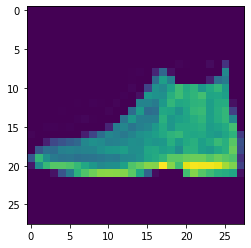

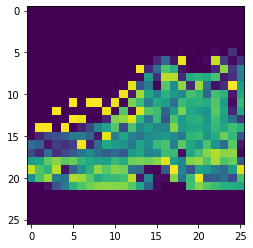

In [334]:
import matplotlib.pyplot as plt

sample1 = np.array(sample.data[0])


marginer = torch.Tensor([[0, 1, 0], [1, -3, 1], [0, 1, 0]])
torch_conv = torch.nn.Conv2d(in_channels=1, kernel_size=3, out_channels=1, stride=1)
torch_conv.weight = torch.nn.Parameter(marginer.reshape(1, 1, 3, 3))
torch_conv.bias = torch.nn.Parameter(torch.zeros(1))
margin1 = torch_conv(sample.data[0].reshape(1, 1, 28, 28).float())


plt.imshow(sample1)
plt.show();

plt.imshow(margin1.byte()[0,0])
plt.show();

In [338]:
l = 0
batch_size = 256
my_conv = torch.nn.Conv2d(in_channels=1, kernel_size=3, out_channels=1, stride=1)


loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=my_conv.parameters(), lr=0.1)
data_loader = torch.utils.data.DataLoader(dataset=sample, batch_size=batch_size, shuffle=True)

for epoch in range(20):
    print("Epoch:", epoch, " Loss:", sum_loss)
    sum_loss = 0
    for batch_X, batch_y in data_loader:
        
        batch_y = torch_conv(batch_X).detach()
        batch_y_hat = my_conv(batch_X)

        l = loss(batch_y_hat, batch_y)
        
        l = l.sum() / batch_size
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        sum_loss += l.item()



Epoch: 0  Loss: 4.442862029918615e-05
Epoch: 1  Loss: 0.011423742609622423
Epoch: 2  Loss: 0.003053594737139065
Epoch: 3  Loss: 0.0014950226886867313
Epoch: 4  Loss: 0.0006177756949909963
Epoch: 5  Loss: 0.0002205637724728149
Epoch: 6  Loss: 6.733984503171087e-05
Epoch: 7  Loss: 1.8024767939550657e-05
Epoch: 8  Loss: 4.044045823548004e-06
Epoch: 9  Loss: 7.650975630824064e-07
Epoch: 10  Loss: 1.2603047094827957e-07
Epoch: 11  Loss: 1.760746887180531e-08
Epoch: 12  Loss: 2.0741323528486455e-09
Epoch: 13  Loss: 2.0042210783794562e-10
Epoch: 14  Loss: 1.5529471724404567e-11
Epoch: 15  Loss: 9.50031993339438e-13
Epoch: 16  Loss: 4.919108108300376e-14
Epoch: 17  Loss: 5.024243662804883e-15
Epoch: 18  Loss: 3.3806026719677355e-15
Epoch: 19  Loss: 2.0817827952440112e-15


In [341]:
my_conv.weight, marginer

(Parameter containing:
 tensor([[[[ 2.9303e-07,  1.0000e+00,  2.4550e-07],
           [ 1.0000e+00, -3.0000e+00,  1.0000e+00],
           [ 2.4269e-07,  1.0000e+00,  2.9929e-07]]]], requires_grad=True),
 tensor([[ 0.,  1.,  0.],
         [ 1., -3.,  1.],
         [ 0.,  1.,  0.]]))

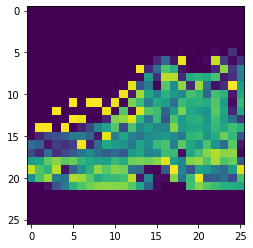

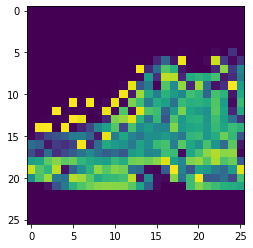

In [340]:
sample1 = np.array(sample.data[0])

margin1_hat = my_conv(sample.data[0].reshape(1, 1, 28, 28).float())


plt.imshow(margin1.byte()[0,0])
plt.show();

plt.imshow(margin1_hat.byte()[0,0])
plt.show();